In [28]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [29]:
# -----------------------
# Konfigurasi yang Dioptimalkan
# -----------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15  # Increased for better convergence
EPOCHS_PHASE2 = 25  # Increased for better fine-tuning
ANNOTATION_JSON = "augmented_output/annotations.json"
USE_COMBINED = True

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset_classification")
train_folder = os.path.join(DATASET_DIR, "train")

In [30]:
# -----------------------
# Class Names
# -----------------------
class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])
num_classes = len(class_names)
class_to_idx = {c:i for i,c in enumerate(class_names)}
print("Detected classes:", class_names)

Detected classes: ['Ganoderma', 'Sehat']



DATASET ANALYSIS

Class Distribution:
Class                Train    Val      Test     Total   
------------------------------------------------------------
Ganoderma            600      63       26       689     
Sehat                387      41       16       444     

Imbalance Ratio: 1.55
✓ Dataset is relatively balanced


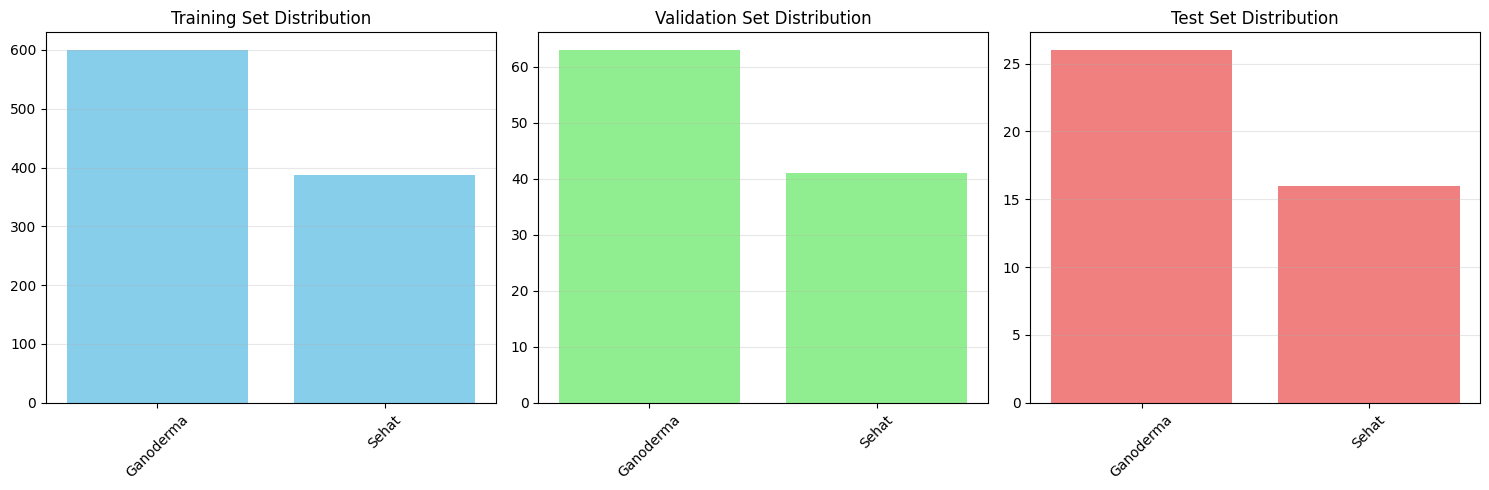

In [31]:
# -----------------------
# Analisis Dataset - OPTIMIZED FOR JUPYTER
# -----------------------
print("\n" + "="*50)
print("DATASET ANALYSIS")
print("="*50)

# Analisis training set
train_counts = {}
for cls in class_names:
    class_path = os.path.join(train_folder, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg','.jpeg','.png'))])
    train_counts[cls] = count

# Analisis validation set
val_folder = os.path.join(DATASET_DIR, "valid")
val_counts = {}
for cls in class_names:
    class_path = os.path.join(val_folder, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg','.jpeg','.png'))])
    val_counts[cls] = count

# Analisis test set
test_folder = os.path.join(DATASET_DIR, "test")
test_counts = {}
for cls in class_names:
    class_path = os.path.join(test_folder, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg','.jpeg','.png'))])
    test_counts[cls] = count

print("\nClass Distribution:")
print(f"{'Class':<20} {'Train':<8} {'Val':<8} {'Test':<8} {'Total':<8}")
print("-" * 60)
for cls in class_names:
    total = train_counts[cls] + val_counts[cls] + test_counts[cls]
    print(f"{cls:<20} {train_counts[cls]:<8} {val_counts[cls]:<8} {test_counts[cls]:<8} {total:<8}")

# Calculate imbalance ratio
train_counts_list = list(train_counts.values())
if min(train_counts_list) > 0:
    imbalance_ratio = max(train_counts_list) / min(train_counts_list)
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 5:
        print("⚠️  WARNING: Highly imbalanced dataset detected!")
    elif imbalance_ratio > 2:
        print("⚠️  WARNING: Moderately imbalanced dataset detected!")
    else:
        print("✓ Dataset is relatively balanced")

# Visualisasi distribusi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Training Set Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(val_counts.keys(), val_counts.values(), color='lightgreen')
plt.title('Validation Set Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(test_counts.keys(), test_counts.values(), color='lightcoral')
plt.title('Test Set Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
random_rotation = tf.keras.layers.RandomRotation(0.1)
random_zoom = tf.keras.layers.RandomZoom(0.1)

def enhanced_augmentations(image, label):
    # Flip horizontal
    image = tf.image.random_flip_left_right(image)
    
    # Color augmentations
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_saturation(image, 0.9, 1.1)
    
    # Keras layers (instance sudah dibuat di luar)
    image = random_rotation(image)
    image = random_zoom(image)
    
    # Clip ke [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

In [35]:
# -----------------------
# Load dan Persiapkan Data - OPTIMIZED
# -----------------------
print("\n" + "="*50)
print("PREPARING DATASETS")
print("="*50)

# Load augmented data
image_paths, labels_idx = [], []
if os.path.exists(ANNOTATION_JSON):
    with open(ANNOTATION_JSON, "r") as f:
        ann = json.load(f)
    for item in ann:
        cls = item.get("class")
        if cls not in class_to_idx: continue
        idx = class_to_idx[cls]
        orig, aug = item.get("original"), item.get("augmented")
        if orig and os.path.exists(orig):
            image_paths.append(orig); labels_idx.append(idx)
        if aug and os.path.exists(aug):
            image_paths.append(aug); labels_idx.append(idx)
print(f"Total augmented images loaded: {len(image_paths)}")

def preprocess_path_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img, tf.one_hot(label, num_classes)

# Create augmented dataset
if len(image_paths) > 0:
    aug_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))
    aug_ds = aug_ds.shuffle(len(image_paths), reshuffle_each_iteration=True)
    aug_ds = aug_ds.map(lambda p,l: preprocess_path_label(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    aug_ds = aug_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    aug_ds = None

# Original datasets dengan cache dan optimasi
ds_original = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=42
)
ds_original = ds_original.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))

# Apply augmentations to original dataset
ds_original_aug = ds_original.map(enhanced_augmentations, num_parallel_calls=tf.data.AUTOTUNE)

# Combine datasets
train_ds = ds_original_aug
if USE_COMBINED and aug_ds is not None:
    train_ds = train_ds.concatenate(aug_ds)

train_ds = train_ds.shuffle(2000, reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

# Validation and test datasets (no augmentation)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR,"valid"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
).map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).prefetch(tf.data.AUTOTUNE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR,"test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
).map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).prefetch(tf.data.AUTOTUNE)

# Calculate actual dataset sizes
train_size = sum([1 for _ in train_ds]) * BATCH_SIZE
val_size = sum([1 for _ in val_ds]) * BATCH_SIZE
test_size = sum([1 for _ in test_ds]) * BATCH_SIZE

print(f"Training samples: ~{train_size}")
print(f"Validation samples: ~{val_size}")
print(f"Test samples: ~{test_size}")


PREPARING DATASETS
Total augmented images loaded: 1974
Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Training samples: ~2976
Validation samples: ~128
Test samples: ~64


In [36]:
# -----------------------
# Calculate Class Weights - OPTIMIZED
# -----------------------
print("\n" + "="*50)
print("CALCULATING CLASS WEIGHTS")
print("="*50)

# Collect all labels from training set
all_labels = []
for _, labels in tf.keras.utils.image_dataset_from_directory(
    train_folder,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
):
    all_labels.extend(labels.numpy())

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Use class weights only if imbalance is significant
if max(train_counts_list) / min(train_counts_list) > 2:
    class_weights = class_weights_dict
    print("Using class weights for training")
else:
    class_weights = None
    print("Dataset balanced, not using class weights")


CALCULATING CLASS WEIGHTS
Found 987 files belonging to 2 classes.
Class weights: {0: np.float64(0.8225), 1: np.float64(1.2751937984496124)}
Dataset balanced, not using class weights


In [37]:
# -----------------------
# Build Model yang Dioptimalkan - ENHANCED
# -----------------------
print("\n" + "="*50)
print("BUILDING IMPROVED MODEL")
print("="*50)

# Base model dengan weights ImageNet
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model untuk phase 1
base_model.trainable = False

# Build model dengan architecture yang lebih robust
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Preprocessing (sesuai dengan EfficientNet)
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

# Base model
x = base_model(x, training=False)

# Enhanced classifier head
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)  # Increased dropout

x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile dengan optimizer yang lebih baik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

model.summary()


BUILDING IMPROVED MODEL


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,030,245 (23.00 MB)

 Trainable params: 1,974,530 (7.53 MB)

 Non-trainable params: 4,055,715 (15.47 MB)

In [38]:
# -----------------------
# Callbacks untuk Training - ENHANCED
# -----------------------
callbacks_phase1 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_phase1.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

callbacks_phase2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=8,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_final.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [39]:
# -----------------------
# Training Two-Phase - OPTIMIZED
# -----------------------
print("\n" + "="*50)
print("PHASE 1: TRAINING CLASSIFIER HEAD")
print("="*50)

# Phase 1: Train classifier saja
history1 = model.fit(
    train_ds,
    epochs=EPOCHS_PHASE1,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)

print("\n" + "="*50)
print("PHASE 2: FINE-TUNING")
print("="*50)

# Unfreeze layer atas base model dengan strategi bertahap
base_model.trainable = True

# Unfreeze secara bertahap - lebih banyak layer yang di-unfreeze
for layer in base_model.layers[:150]:
    layer.trainable = False
for layer in base_model.layers[150:]:
    layer.trainable = True

print(f"Trainable layers: {sum([l.trainable for l in base_model.layers])}/{len(base_model.layers)}")

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', 
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

# Phase 2: Fine-tuning
history2 = model.fit(
    train_ds,
    epochs=EPOCHS_PHASE2,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1
)

# Combine histories
combined_history = {}
for key in history1.history.keys():
    combined_history[key] = history1.history[key] + history2.history[key]


PHASE 1: TRAINING CLASSIFIER HEAD
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.5180 - loss: 18.1207 - precision: 0.5180 - recall: 0.5180
Epoch 1: val_accuracy improved from -inf to 0.60577, saving model to best_model_phase1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 101s 815ms/step - accuracy: 0.5181 - loss: 18.1054 - precision: 0.5181 - recall: 0.5181 - val_accuracy: 0.6058 - val_loss: 13.2808 - val_precision: 0.6058 - val_recall: 0.6058 - learning_rate: 0.0010
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.5558 - loss: 12.0257 - precision: 0.5558 - recall: 0.5558
Epoch 2: val_accuracy did not improve from 0.60577
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 773ms/step - accuracy: 0.5557 - loss: 12.0111 - precision: 0.5557 - recall: 0.5557 - val_accuracy: 0.6058 - val_loss: 7.9924 - val_precision: 0.6058 - val_recall: 0.6058 - learning_rate: 0.0010
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.5440 - loss: 7.2076 - precision: 0.5440 - recall: 0.5440
Epoch 3: val_accuracy did not improve from 0.60577
93/93 ━━━━━━━━━━━━━━━━━━━━ 76s 770ms/step - accuracy: 0.5440 - loss: 7.1986 - precision: 0.5440 - recall: 0.5440 - val_accuracy: 0.6058 - val_loss: 4.7456 - val_precision: 0.6058 - val_recall: 0.6058

93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5427 - loss: 13.3002 - precision: 0.5427 - recall: 0.5427 - val_accuracy: 0.6058 - val_loss: 12.5162 - val_precision: 0.6058 - val_recall: 0.6058 - learning_rate: 1.0000e-04
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5258 - loss: 12.5302 - precision: 0.5258 - recall: 0.5258
Epoch 2: val_accuracy did not improve from 0.60577
93/93 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5259 - loss: 12.5280 - precision: 0.5259 - recall: 0.5259 - val_accuracy: 0.6058 - val_loss: 11.7839 - val_precision: 0.6058 - val_recall: 0.6058 - learning_rate: 1.0000e-04
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5465 - loss: 11.7020 - precision: 0.5465 - recall: 0.5465
Epoch 3: val_accuracy did not improve from 0.60577
93/93 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5464 - loss: 11.7002 - precision: 0.5464 - recall: 0.5464 - val_accuracy: 0.6058 - val_loss: 10.9904 - val_precision: 0.6058 - val_recall: 0.6058 


COMPREHENSIVE EVALUATION
🎯 Test Accuracy: 0.6190
📉 Test Loss: 12.5070
✅ Test Precision: 0.6190
✅ Test Recall: 0.6190
⏱️  Inference time per image: 0.2383 detik
🎯 F1-Score: 0.4734
🎯 Overall Accuracy: 0.6190


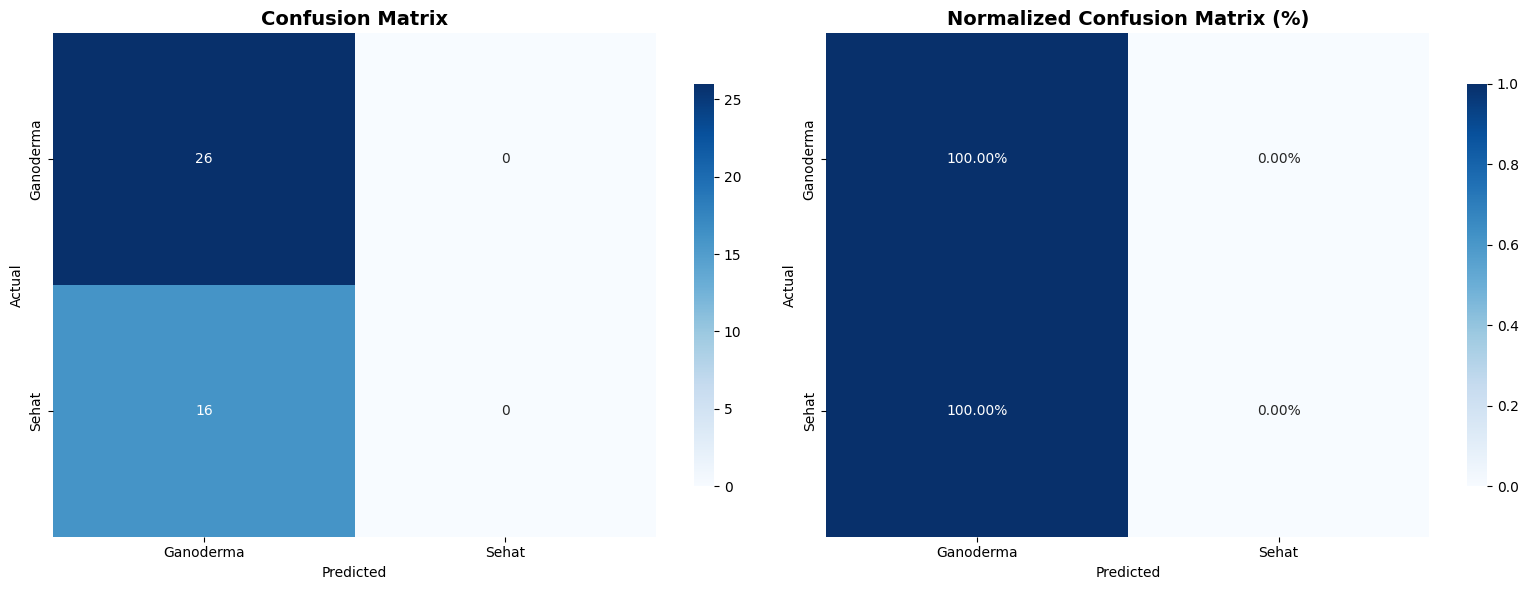


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   Ganoderma     0.6190    1.0000    0.7647        26
       Sehat     0.0000    0.0000    0.0000        16

    accuracy                         0.6190        42
   macro avg     0.3095    0.5000    0.3824        42
weighted avg     0.3832    0.6190    0.4734        42



c:\Users\wangp\Desktop\cnn-ganoderma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wangp\Desktop\cnn-ganoderma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wangp\Desktop\cnn-ganoderma\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

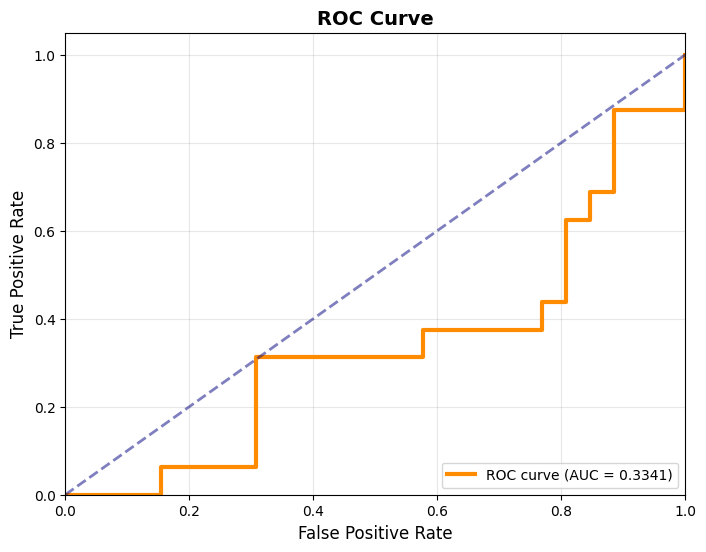

In [40]:
# -----------------------
# Evaluasi Mendalam - ENHANCED
# -----------------------
print("\n" + "="*50)
print("COMPREHENSIVE EVALUATION")
print("="*50)

# Basic evaluation
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds, verbose=0)
print(f"🎯 Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")

# Predictions
y_true, y_pred, y_prob = [], [], []
start = time.time()

for x, y in test_ds:
    probs = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(probs, axis=1))
    y_prob.extend(probs)

end = time.time()
print(f"⏱️  Inference time per image: {(end-start)/len(y_true):.4f} detik")

# Additional metrics
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 F1-Score: {f1:.4f}")
print(f"🎯 Overall Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'shrink': 0.8})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'shrink': 0.8})
plt.title('Normalized Confusion Matrix (%)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification Report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ROC Curve for binary classification
if num_classes == 2:
    y_prob_arr = np.array(y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob_arr[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
elif num_classes > 2:
    # Plot class-wise accuracy
    class_accuracy = []
    for i in range(num_classes):
        class_mask = np.array(y_true) == i
        if np.sum(class_mask) > 0:
            class_acc = np.mean(np.array(y_pred)[class_mask] == i)
            class_accuracy.append(class_acc)
        else:
            class_accuracy.append(0)
    
    plt.figure(figsize=(10, 6))
    plt.barh(class_names, class_accuracy, color='lightseagreen')
    plt.xlabel('Accuracy')
    plt.title('Class-wise Accuracy', fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    for i, v in enumerate(class_accuracy):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


SAMPLE PREDICTIONS


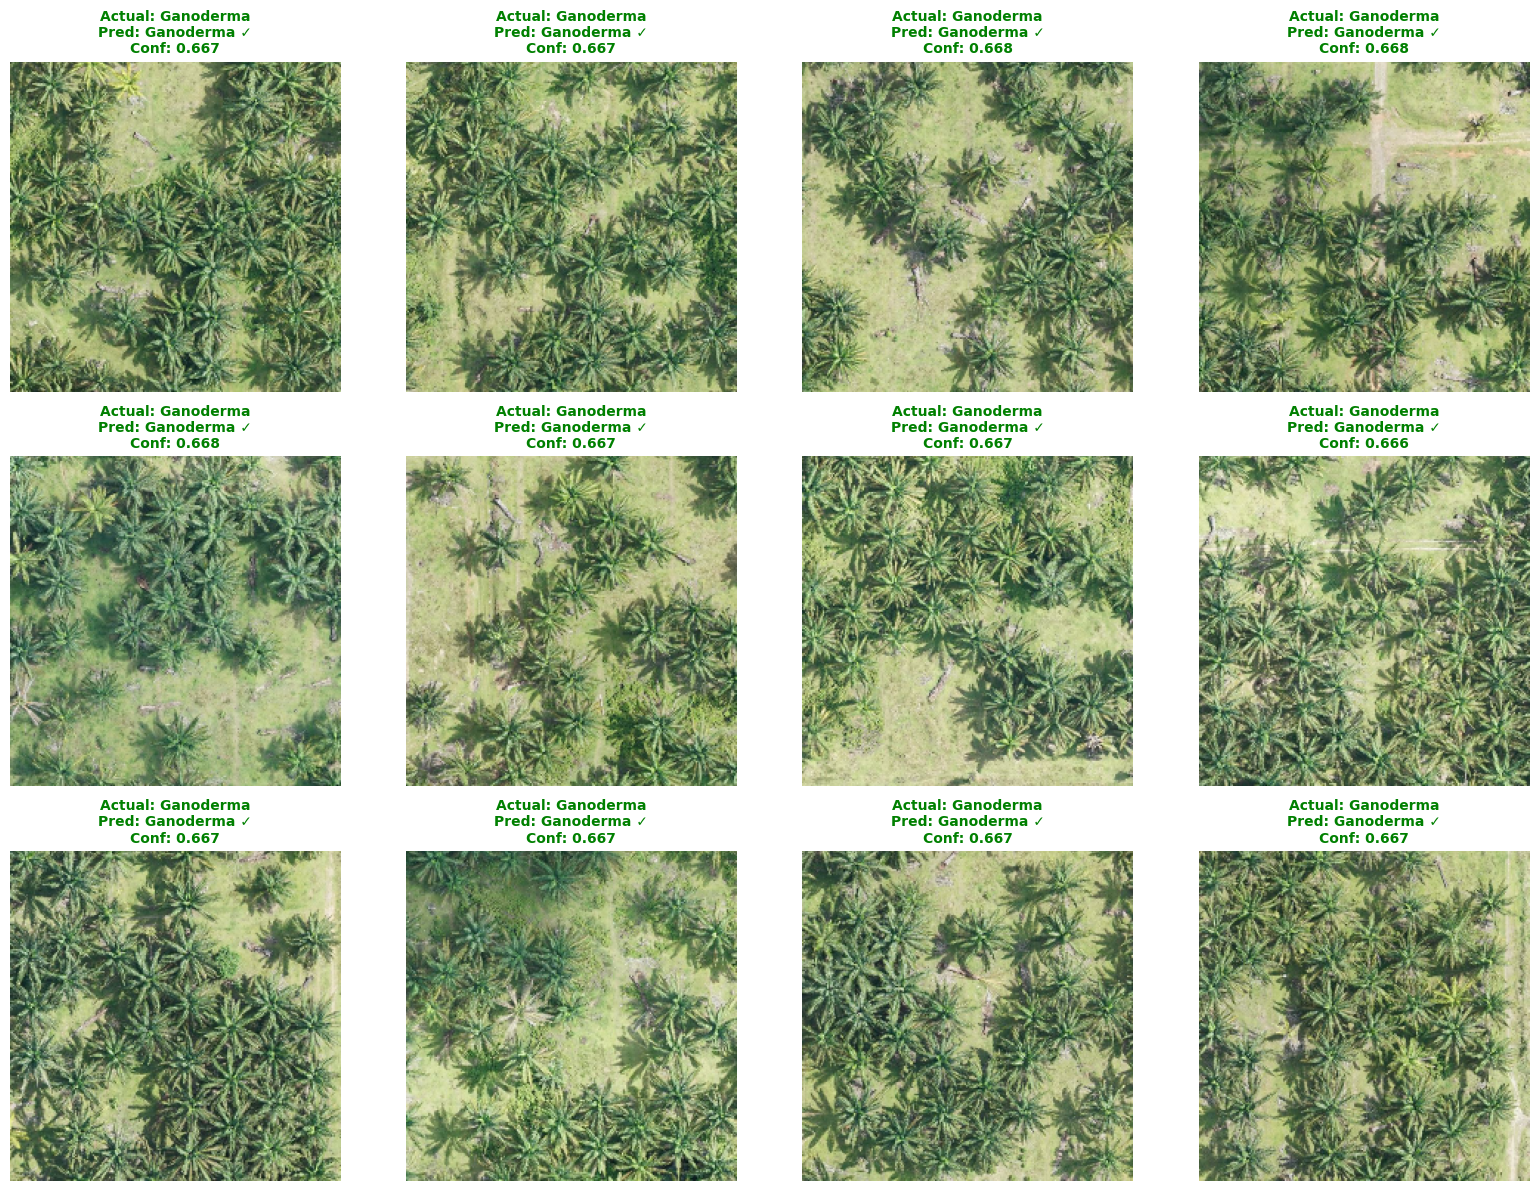

In [41]:
# -----------------------
# Visualisasi Sample Predictions - ENHANCED
# -----------------------
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

plt.figure(figsize=(16, 12))

for images, labels in test_ds.take(1):
    predictions = model.predict(images, verbose=0)
    
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        
        # Display image
        plt.imshow(images[i])
        
        # Get actual and predicted labels
        actual_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i])
        
        # Set title color based on correctness
        color = 'green' if actual_label == predicted_label else 'red'
        correctness = "✓" if actual_label == predicted_label else "✗"
        
        plt.title(f'Actual: {actual_label}\nPred: {predicted_label} {correctness}\nConf: {confidence:.3f}', 
                 color=color, fontsize=10, fontweight='bold')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [42]:
# -----------------------
# Performance Summary
# -----------------------
print("\n" + "="*60)
print("🎉 FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"🏆 Final Test Accuracy: {test_acc:.4f}")
print(f"🎯 F1-Score: {f1:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")

# Calculate improvement if previous model exists
if 'final_accuracy' in locals():
    improvement = test_acc - final_accuracy
    print(f"📈 Accuracy Improvement: {improvement:.4f}")

print("\n" + "="*60)
print("✅ TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)


🎉 FINAL PERFORMANCE SUMMARY
🏆 Final Test Accuracy: 0.6190
🎯 F1-Score: 0.4734
✅ Precision: 0.6190
✅ Recall: 0.6190

✅ TRAINING COMPLETED SUCCESSFULLY!
